# **Import the libraries**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import ogr, gdal
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.layers import Input, Activation, Dense, Conv2D, MaxPool2D, Dropout, concatenate, UpSampling2D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
import tensorflow.keras.backend as K
#from keras.layers.merge import concatenate, add

import os
from skimage.util.shape import view_as_windows
from sklearn.model_selection import train_test_split

In [2]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# **Define the functions**

In [2]:
def load_tiff_image(image):
    print (image)
    gdal_header = gdal.Open(image)
    img = gdal_header.ReadAsArray()
    return img

def normalization(image):
    return np.array(image)/127.5 - 1.

def extract_patches(image, reference, patch_size, stride):
    patches_out = []
    label_out = []
    window_shape = patch_size
    window_shape_array = (window_shape, window_shape, image.shape[2])
    window_shape_ref = (window_shape, window_shape)
    patches_array = np.array(view_as_windows(image, window_shape_array, step = stride))
    
    patches_ref = np.array(view_as_windows(reference, window_shape_ref, step = stride))
    
    print(patches_array.shape)
    num_row,num_col,p,row,col,depth = patches_array.shape
    
    patches_array = patches_array.reshape(num_row*num_col,row,col,depth)
    print(patches_array.shape)
    patches_ref = patches_ref.reshape(num_row*num_col,row,col)
    print(patches_ref.shape)
    
    return patches_array, patches_ref
    


def unet(input_shape, n_classes):
    
    input_img = Input(input_shape)
    
    # You must complete the U-Net architecture
    
    #Contractive stage
    # conv block 1
    n_filters = 64
    conv1_1 = Conv2D(n_filters , (3 , 3) , activation='relu' , padding='same', name = 'conv1_1')(input_img) 
    conv1_2 = Conv2D(n_filters , (3 , 3) , activation='relu' , padding='same', name = 'conv1_2')(conv1_1)
    pool1 = MaxPool2D((2 , 2), name = 'pool1')(conv1_2)
    # conv block 2 -- n_f=128
    conv2_1 = Conv2D(n_filters*2 , (3 , 3) , activation='relu' , padding='same', name = 'conv2_1')(pool1) 
    conv2_2 = Conv2D(n_filters*2, (3 , 3) , activation='relu' , padding='same', name = 'conv2_2')(conv2_1)
    pool2 = MaxPool2D((2 , 2), name = 'pool2')(conv2_2)
    # conv block 3 -- n_f=256
    conv3_1 = Conv2D(n_filters*4 , (3 , 3) , activation='relu' , padding='same', name = 'conv3_1')(pool2) 
    conv3_2 = Conv2D(n_filters*4, (3 , 3) , activation='relu' , padding='same', name = 'conv3_2')(conv3_1)
    pool3 = MaxPool2D((2 , 2), name = 'pool3')(conv3_2)
    # conv block 4 -- n_f=512
    conv4_1 = Conv2D(n_filters*8 , (3 , 3) , activation='relu' , padding='same', name = 'conv4_1')(pool3) 
    conv4_2 = Conv2D(n_filters*8, (3 , 3) , activation='relu' , padding='same', name = 'conv4_2')(conv4_1)
    pool4 = MaxPool2D((2 , 2), name = 'pool4')(conv4_2)
    
    # Middle
    # conv block 5 n_f=1024
    conv5_1 = Conv2D(n_filters*16 , (3 , 3) , activation='relu' , padding='same', name = 'conv5_1')(pool4) 
    conv5_2 = Conv2D(n_filters*16, (3 , 3) , activation='relu' , padding='same', name = 'conv5_2')(conv5_1)
    
    # Expansive stage
    # Upsampling conv block 1 --  n_f=512
    up6 = Conv2D(n_filters*8, (3 , 3), activation = 'relu', padding = 'same', name = 'up6')(UpSampling2D(size = (2,2))(conv5_2))
    merge6 = concatenate([conv4_2,up6], axis = 3, name='merge6')
    conv6_1 = Conv2D(n_filters*8 , (3 , 3) , activation='relu' , padding='same', name = 'conv6_1')(merge6)
    conv6_2 = Conv2D(n_filters*8 , (3 , 3) , activation='relu' , padding='same', name = 'conv6_2')(conv6_1)
    
    # Upsampling conv block 2 --  n_f=256
    up7 = Conv2D(n_filters*4, (3 , 3), activation = 'relu', padding = 'same', name = 'up7')(UpSampling2D(size = (2,2))(conv6_2))
    merge7 = concatenate([conv3_2,up7], axis = 3, name='merge7')
    conv7_1 = Conv2D(n_filters*4 , (3 , 3) , activation='relu' , padding='same', name = 'conv7_1')(merge7)
    conv7_2 = Conv2D(n_filters*4 , (3 , 3) , activation='relu' , padding='same', name = 'conv7_2')(conv7_1)
    
    # Upsampling conv block 3 --  n_f=128
    up8 = Conv2D(n_filters*2, (3 , 3), activation = 'relu', padding = 'same', name = 'up8')(UpSampling2D(size = (2,2))(conv7_2))
    merge8 = concatenate([conv2_2,up8], axis = 3, name='merge8')
    conv8_1 = Conv2D(n_filters*2 , (3 , 3) , activation='relu' , padding='same', name = 'conv8_1')(merge8)
    conv8_2 = Conv2D(n_filters*2 , (3 , 3) , activation='relu' , padding='same', name = 'conv8_2')(conv8_1)
    
    # Upsampling conv block 4 --  n_f=64
    up9 = Conv2D(n_filters, (3 , 3), activation = 'relu', padding = 'same', name = 'up9')(UpSampling2D(size = (2,2))(conv8_2))
    merge9 = concatenate([conv1_2,up9], axis = 3, name='merge9')
    conv9_1 = Conv2D(n_filters , (3 , 3) , activation='relu' , padding='same', name = 'conv9_1')(merge9)
    conv9_2 = Conv2D(n_filters , (3 , 3) , activation='relu' , padding='same', name = 'conv9_2')(conv9_1)
    
    #conv9_3 = Conv2D(2, (3 , 3) , activation='relu' , padding='same', name = 'conv9_3')(conv9_2)
    
    # Softmax layer - output
    output = Conv2D(n_classes,(1,1), activation = 'softmax')(conv9_2)
    return Model(inputs = input_img, outputs = output, name='U-Net') 

def weighted_categorical_crossentropy(weights):
        """
        A weighted version of keras.objectives.categorical_crossentropy
        
        Variables:
            weights: numpy array of shape (C,) where C is the number of classes
        
        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """
        weights = K.variable(weights)
        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            loss = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
            loss = loss * weights 
            loss = - K.mean(loss, -1)
            return loss
        return loss

def Train_model(net, patches_train, patches_tr_lb_h, patches_val, patches_val_lb_h, batch_size, epochs, patience, delta):
    print('Start training...')
    print(epochs)
    best_score = 0
    min_loss = 200
    cont = 0
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc =[]
    for epoch in range(epochs):
        loss_tr = np.zeros((1 , 2))
        loss_val = np.zeros((1 , 2))
        # Computing the number of batchs
        n_batchs_tr = patches_train.shape[0]//batch_size
        # Random shuffle the data
        patches_train , patches_tr_lb_h = shuffle(patches_train , patches_tr_lb_h , random_state = 42)

        # Training the network per batch
        for  batch in range(n_batchs_tr):
            x_train_b = patches_train[batch * batch_size : (batch + 1) * batch_size , : , : , :]
            y_train_h_b = patches_tr_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
            loss_tr = loss_tr + net.train_on_batch(x_train_b , y_train_h_b)

        # Training loss
        loss_tr = loss_tr/n_batchs_tr
        #print("%d [Training loss: %f , Train acc.: %.2f%%]" %(epoch , loss_tr[0 , 0], 100*loss_tr[0 , 1]))

        # Computing the number of batchs
        n_batchs_val = patches_val.shape[0]//batch_size

        # Evaluating the model in the validation set
        for  batch in range(n_batchs_val):
            x_val_b = patches_val[batch * batch_size : (batch + 1) * batch_size , : , : , :]
            y_val_h_b = patches_val_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
            loss_val = loss_val + net.test_on_batch(x_val_b , y_val_h_b)

        # validation loss
        loss_val = loss_val/n_batchs_val
        #print("%d [Validation loss: %f , Validation acc.: %.2f%%]" %(epoch , loss_val[0 , 0], 100*loss_val[0 , 1]))
        train_loss = loss_tr[0 , 0]
        train_acc = loss_tr[0 , 1]
        val_loss = loss_val[0 , 0]
        val_acc = loss_val[0 , 1]
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        total_val_loss.append(val_loss)
        total_val_acc.append(val_acc)
        print(f"Epoch: {epoch} \t Training loss: {train_loss :.2f} \t Train acc.: {100*train_acc:.2f}% \t Validation loss: {val_loss :.2f} \t Validation acc.: {100*val_acc:.2f}%")
        # Add early stop
        # Save the model when loss is minimum
        # Stop the training if the loss don't decreases after patience epochs
        if val_loss >= min_loss + delta:
            cont += 1
            print(f'EarlyStopping counter: {cont} out of {patience}')
            if cont >= patience:
                print("Early Stopping! \t Training Stopped")
                print("Saving model...")
                net.save('weights/model_early_stopping.h5')
                return total_train_loss, total_train_acc, total_val_loss, total_val_acc   
        else:
            cont = 0
            #best_score = score
            min_loss = val_loss
            print("Saving best model...")
            net.save('weights/best_model.h5')
            
    return total_train_loss, total_train_acc, total_val_loss, total_val_acc

## Load Images

In [4]:
root_path = './'
# Load images
img_train_path = 'Image_Train.tif'
img_train = load_tiff_image(os.path.join(root_path, img_train_path)).astype(np.float32)
# Normalizes the image
print(img_train.shape)
img_train_normalized = normalization(img_train)
# Transform the image into W x H x C shape
img_train_normalized = img_train_normalized.transpose((1,2,0))
print(img_train_normalized.shape)

# Load reference
img_train_ref_path = 'Reference_Train.tif'
img_train_ref = load_tiff_image(os.path.join(root_path, img_train_ref_path))
img_train_ref = img_train_ref.transpose((1,2,0))
print(img_train_ref.shape)

./Image_Train.tif
(3, 2565, 1919)
(2565, 1919, 3)
./Reference_Train.tif
(2565, 1919, 3)


In [5]:
# Create binarized matrix
w = img_train_ref.shape[0]
h = img_train_ref.shape[1]
c = img_train_ref.shape[2]
#binary_img_train_ref = np.zeros((1,w,h))
binary_img_train_ref = np.full((w,h), -1)
label_dict = {'(255, 255, 255)': 0, '(0, 255, 0)': 1, '(0, 255, 255)': 2, '(0, 0, 255)': 3, '(255, 255, 0)': 4}
for i in range(w):
    for j in range(h):
        r = img_train_ref[i][j][0]
        g = img_train_ref[i][j][1]
        b = img_train_ref[i][j][2]
        rgb = (r,g,b)
        rgb_key = str(rgb)
        binary_img_train_ref[i][j] = label_dict[rgb_key]

dict_keys(['(255, 255, 255)', '(0, 255, 0)', '(0, 255, 255)', '(0, 0, 255)', '(255, 255, 0)'])


In [7]:
# # Uncomment this if you want to check binary_img_train_ref
# for i in range(w):
#     for j in range(h):
#         pixel = binary_img_train_ref[i][j]
#         if pixel == -1:
#             print('achou')
#         if pixel == 5:
#             print('achou 5 wtf')

## Separate pixels per class

In [8]:
pixels_per_class = {0:0, 1:0, 2:0, 3:0, 4:0}
for i in range(w):
    for j in range(h):
        class_pixel = binary_img_train_ref[i][j]
        if class_pixel == 0:
            pixels_per_class[0] += 1
        elif class_pixel == 1:
            pixels_per_class[1] += 1
        elif class_pixel == 2:
            pixels_per_class[2] += 1
        elif class_pixel == 3:
            pixels_per_class[3] += 1
        elif class_pixel == 4:
            pixels_per_class[4] += 1

print(pixels_per_class)

{0: 1132698, 1: 1653521, 2: 1255273, 3: 867583, 4: 13160}


## Extract Patches

In [9]:
patch_size = 32
stride = patch_size // 2
#stride = patch_size
patches_train, patches_train_ref = extract_patches(img_train_normalized, binary_img_train_ref, patch_size, stride)

(159, 118, 1, 32, 32, 3)
(18762, 32, 32, 3)
(18762, 32, 32)


/home/thimabru/.virtualenvs/base/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


## Parameters

In [10]:
root_path = './'
batch_size = 32
epochs = 100
channels = 3
num_classes = 5
filepath = root_path
name = 'U-Net'

## One hot enconding

In [11]:
patches_train_ref_h = tf.keras.utils.to_categorical(patches_train_ref, num_classes)
patches_tr , patches_tr_ref_h = shuffle(patches_train , patches_train_ref_h , random_state = 42)

In [12]:
patches_train, patches_val, patches_tr_lb_h, patches_val_lb_h = train_test_split(patches_tr, patches_tr_ref_h, test_size=0.2, random_state=42)
print(patches_train.shape, patches_val.shape)
print(patches_tr_lb_h.shape, patches_val_lb_h.shape)

(15009, 32, 32, 3) (3753, 32, 32, 3)
(15009, 32, 32, 5) (3753, 32, 32, 5)


## Set weights of weighted ategorical crossentropy

In [ ]:
total_pixels = img_train_normalized.shape[0] * img_train_normalized.shape[1]
#total_pixels = 2565*1919
num_classes=5
weights = np.zeros(num_classes)
for i in range(num_classes):
    weights[i] = total_pixels / pixels_per_class[i]
    
# weights_sum = np.sum(weights)
# for i in range(num_classes):
#     weights[i] = weights[i] / weights_sum
    
print(weights)
print(np.sum(weights))

## Train the model

adam = Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999)
input_shape = (patch_size, patch_size, channels)
net = unet(input_shape, num_classes)
loss = weighted_categorical_crossentropy(weights)
net.summary()
net.compile(loss = loss, optimizer=adam , metrics=['accuracy'])

In [14]:
history = Train_model(net, patches_train, patches_tr_lb_h, patches_val, patches_val_lb_h, 
            batch_size, epochs, patience=10, delta=0.001)

Start training...
100
Epoch: 0 	 Training loss: 3.98 	 Train acc.: 31.31% 	 Validation loss: 2.94 	 Validation acc.: 34.88%
Saving best model...
Epoch: 1 	 Training loss: 2.78 	 Train acc.: 34.10% 	 Validation loss: 2.46 	 Validation acc.: 35.82%
Saving best model...
Epoch: 2 	 Training loss: 2.47 	 Train acc.: 45.03% 	 Validation loss: 2.15 	 Validation acc.: 47.20%
Saving best model...
Epoch: 3 	 Training loss: 2.09 	 Train acc.: 59.18% 	 Validation loss: 2.37 	 Validation acc.: 61.68%
EarlyStopping counter: 1 out of 10
Epoch: 4 	 Training loss: 1.86 	 Train acc.: 66.81% 	 Validation loss: 1.72 	 Validation acc.: 70.69%
Saving best model...
Epoch: 5 	 Training loss: 1.68 	 Train acc.: 70.00% 	 Validation loss: 1.52 	 Validation acc.: 72.74%
Saving best model...
Epoch: 6 	 Training loss: 1.48 	 Train acc.: 71.57% 	 Validation loss: 1.27 	 Validation acc.: 73.67%
Saving best model...
Epoch: 7 	 Training loss: 1.38 	 Train acc.: 73.59% 	 Validation loss: 1.18 	 Validation acc.: 75.06%
S

## Plot training history

In [15]:
def graph_training_history(history):
    loss_train = history[0]
    acc_train = history[1]
    loss_test = history[2]
    acc_test = history[3]
    plt.rcParams['axes.facecolor']='white'
    fig = plt.figure(1)

    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(acc_train)
    plt.plot(acc_test)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.tight_layout()

    # summarize history for loss
    plt.subplot(122)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout()
    
    plt.show()
    fig.savefig('weights/history.png', dpi=fig.dpi)

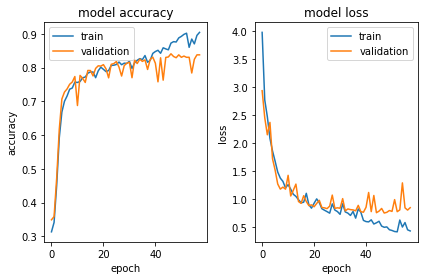

In [16]:
graph_training_history(history)